# Visual Odometry 

In [287]:
# tools
import pandas as pd 
import numpy as np 
import cv2 as cv 
import os 

# visualisation 
import matplotlib.pyplot as plt 
from IPython.display import clear_output


In [ ]:
# ---> functions
def read_calib(path_calib_seq):
    """
    Function to read the intrinsic parameters 
    and the projection matrix 
    """

    params = pd.read_csv(path_calib_seq, header=None, sep=' ').to_numpy()[:, 1:]
    P = np.array(params[0].reshape(3, 4), dtype=np.float32)
    K = P[:3, :3]

    return P, K

def read_pose(pose):
    
    """
    This function takes the pose and returns 
    the rotation matrix (R) and translation (T)
    """
    pose = pose.reshape(3, 4)
    R    = pose[:3, :3]
    T    = pose[:, -1]
    
    return R, T
    
def transf_hom(rotation : np.array, translation : np.array):

    """
    Function to recover homogeneous coordinates 
    """


    pose_hom = np.eye(4, dtype=np.float32)
    pose_hom[:3, :3] = rotation
    pose_hom[:3, -1] = translation

    return pose_hom

def get_keypoints(img1, img2):
    
    """
    Function to find correspondances between two frames 

    input  : two frames 
    output : pair of corresponding points 
    """

    # Detect features 
    max_num_features         = 3000
    orb                      = cv.ORB_create(max_num_features)
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    # FLANN parameters for LSH (suitable for binary descriptors like ORB)
    FLANN_INDEX_LSH = 6
    index_params    = dict(algorithm=FLANN_INDEX_LSH,
                        table_number=6,  # 12
                        key_size=12,     # 20
                        multi_probe_level=1)  # 2
    search_params   = dict(checks=50)  # or pass empty dictionary

    # Create FLANN-based matcher
    flann   = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Find corresponding points 
    pts1 = []
    pts2 = []
    
    # Ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(keypoints2[m.trainIdx].pt)
            pts1.append(keypoints1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    return (pts1, pts2)

def get_pose(pts1, pts2, cameraMatrix):

    """
    Function to recover the rootation and translation between 
    two corresponding points 
    """

    # Compute essential matrix 
    E, mask = cv.findEssentialMat(pts1, pts2, cameraMatrix)

    # recover pose 
    _, R, T, mask = cv.recoverPose(E, pts1, pts2, cameraMatrix)

    return R, T



## Feature detector 

For the feature detectioon we are going to use ORB algorithm

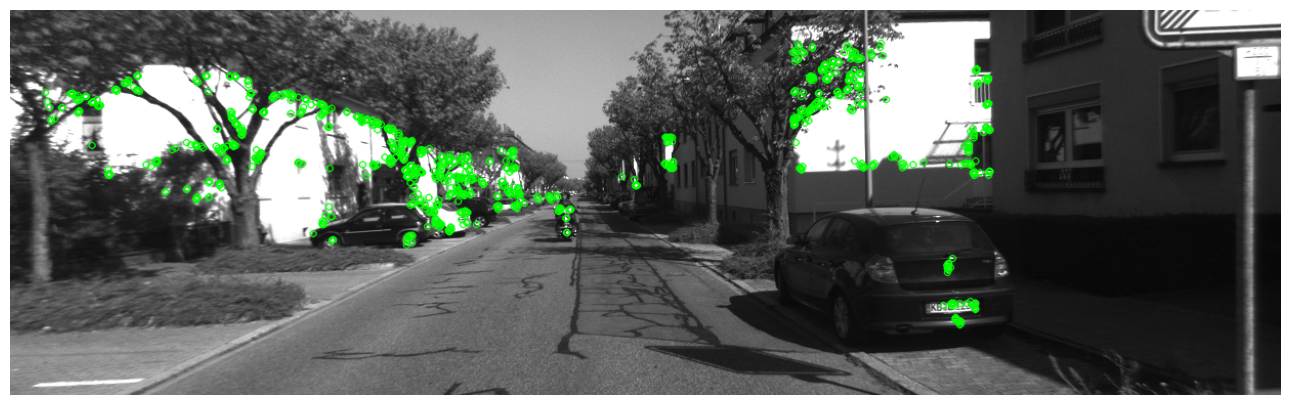

In [309]:
# frames path
num_seq   = "00"
dir_path  = "./gray_images/sequences/" + num_seq + "/image_0"
img_list  = sorted(os.listdir(dir_path))

# read a frame
num_frame = 0
img       = cv.imread(os.path.join(dir_path, img_list[num_frame]), cv.IMREAD_GRAYSCALE)

# create ORB object 
max_num_features       = 1000
orb                    = cv.ORB_create(max_num_features)
keypoints, descriptors = orb.detectAndCompute(img, None)

# draw features 
img2 = cv.drawKeypoints(img, keypoints, None, color=(0,255,0), flags=0)
plt.figure(figsize=(20, 5))
plt.imshow(img2) 
plt.axis("off")
plt.show()

## Feature matching 

In order to match correspondances between features we use the FLANN algorithm 

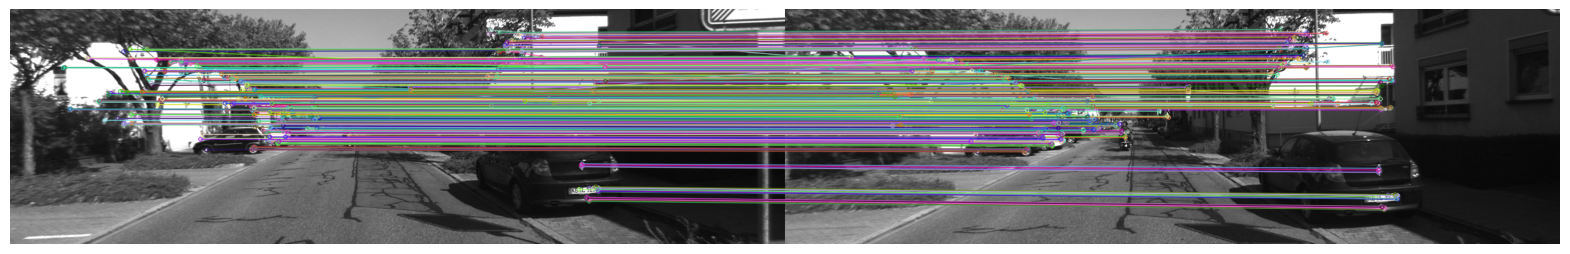

In [310]:
img1 = cv.imread(os.path.join(dir_path, img_list[0]), cv.IMREAD_GRAYSCALE)
img2 = cv.imread(os.path.join(dir_path, img_list[1]), cv.IMREAD_GRAYSCALE)

max_num_features         = 1000
orb                      = cv.ORB_create(max_num_features)
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# FLANN parameters for LSH (suitable for binary descriptors like ORB)
FLANN_INDEX_LSH = 6
index_params    = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=6,  # 12
                    key_size=12,     # 20
                    multi_probe_level=1)  # 2
search_params   = dict(checks=50)  # or pass empty dictionary

# Create FLANN-based matcher
flann   = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to filter good matches (Lowe's ratio test)
good_matches = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good_matches.append(m)

# Draw matches
img_matches = cv.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 5))
plt.imshow(img_matches) 
plt.axis("off")
plt.show()

## Recover pose

In [312]:
path_calib_seq = "./gray_images/sequences/" + num_seq + "/calib.txt"
P, K           = read_calib(path_calib_seq)

# Find corresponding points 
pts1 = []
pts2 = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(keypoints2[m.trainIdx].pt)
        pts1.append(keypoints1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
E, mask = cv.findEssentialMat(pts1, pts2, cameraMatrix=K)

# recover pose 
_, R, T, mask = cv.recoverPose(E, pts1, pts2, cameraMatrix=K)

## Draw trajectories 

In [322]:
t = np.array([2, 2, 2])
np.hstack([t, 1])
P

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]], dtype=float32)

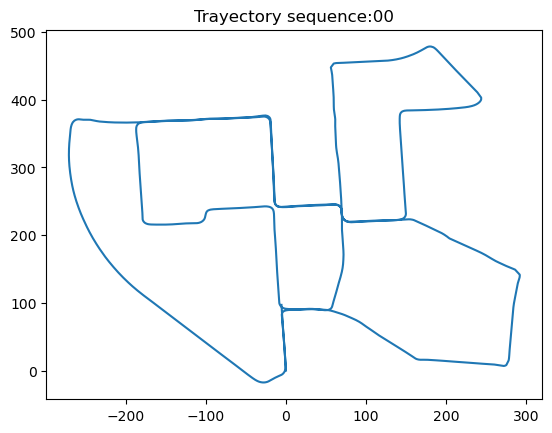

In [324]:
poses_path = "./dataset_poses/poses/00.txt"
poses_df   = pd.read_csv(poses_path, header=None, sep=' ')

poses   = poses_df.apply(lambda row: read_pose(row.values), axis=1)
img_pts = []
for pose in poses:
    _ , T = pose
    x, y, z = T
    img_pts.append(np.array([x, z]))

img_pts = np.stack(img_pts)

plt.plot(img_pts[:, 0], img_pts[:, 1])
plt.title('Trayectory sequence:' + num_seq)
plt.show()